<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/v5_keras_resnet50_pretrain_0.94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Library

In [3]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.5f}".format

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import os
from os import listdir
from os.path import isfile, join
import cv2
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Average
from tensorflow.keras import optimizers
tf.__version__

'2.8.2'

In [30]:
# Visualization
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import skimage.morphology as morp
from skimage.filters import rank
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensoFlow Version:  2.8.2


In [31]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn"

In [32]:
import os
os.chdir(data_path)

In [33]:
data = []
labels = []

height = 224
width = 224
channels = 3
num_classes = 43

In [8]:
# for i in range(num_classes) :
#     path = f'./data/Train/{i}/'
#     Class = os.listdir(path)
#     for a in Class:
#         image = cv2.imread(path + a)
#         image_from_array = Image.fromarray(image, 'RGB')
#         size_image = image_from_array.resize((height, width))
#         data.append(np.array(size_image))
#         labels.append(i)

# data = np.array(data)
# labels = np.array(labels)

# import pickle
# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data_224.pkl","wb") as f:
#     pickle.dump(data, f)

# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label_224.pkl","wb") as f:
#     pickle.dump(labels, f)

### 데이터 로드

In [34]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data_224.pkl","rb") as f:
    data = pickle.load(f)
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label_224.pkl","rb") as f:
    labels = pickle.load(f)

In [35]:
print(data.shape)
print(labels.shape)

(26010, 224, 224, 3)
(26010,)


In [36]:
X = data
y = tf.one_hot(labels, num_classes).numpy()

### Train, Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True, stratify=y)

In [38]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (20808, 224, 224, 3)
Test Shape : (5202, 224, 224, 3)


### 전처리

In [ ]:
def Scaler(data_X,method = 'MinMax'):
  X = data_X.copy()
  X = X.astype(np.float64)

  if method == 'Divide255':
    X = X/255.0

  elif method == 'Standard':
    for a in X:
      for i in range(len(['r','g','b'])):
        mean_ = a[:,:,i].mean()
        std_ = a[:,:,i].std()
        a[:,:,i] = (a[:,:,i] - mean_)/std_

  elif method == 'MinMax':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = (a[:,:,i] - min_)/(max_ - min_)

  elif method == 'MinMax255':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = ((a[:,:,i] - min_)/(max_ - min_))*255
    return np.array(X,dtype='uint8')      

  return X

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return np.array(image)

def img_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    image_from_array = Image.fromarray(final, 'RGB')
    size_image = image_from_array.resize((height, width))

    return np.array(size_image)

def preprocessing(data_X):
  data = []
  for img in data_X:
    img = img_contrast(to_grayscale_then_rgb(img))
    data.append(img)
  data = np.array(data)

  return data 

def preprocessing_gray(data_X):
  data = []
  for img in data_X:
    img = to_grayscale_then_rgb(img)
    data.append(img)
  data = np.array(data)

  return data 

In [ ]:
X = preprocessing_gray(Scaler(X, 'MinMax255'))

In [ ]:
print(X.shape)
print(y.shape)

(26010, 32, 32, 3)
(26010, 43)


#### Data OverSampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler 

train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

oversample = RandomOverSampler(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train = X_train.reshape(-1,width, height,3)

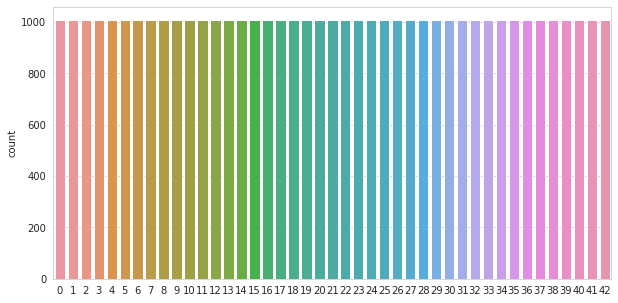

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(np.argmax(y_train, axis=1))

### Data Augmentation

In [14]:
def to_grayscale_then_rgb(img):
    img = img
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)
    return np.array(img)

def img_contrast(img):
    print(img.shape)
    return img
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    image_from_array = Image.fromarray(final, 'RGB')
    size_image = image_from_array.resize((img[0].shape[0], img[0].shape[1]))

    return np.array(size_image)

def preprocessing(img):
    img = to_grayscale_then_rgb(img)
    return img

In [39]:
train_datagen = ImageDataGenerator(
    # preprocessing_function=preprocessing,
    brightness_range=[0.6, 0.9],
    zoom_range=0.2,
    width_shift_range=0.2,    
    height_shift_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    # preprocessing_function=preprocessing,
)

In [40]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size = 32
) 

valid_generator = valid_datagen.flow(
    X_test, y_test,
    batch_size = 32,
    shuffle=False
)

#### Aug Test

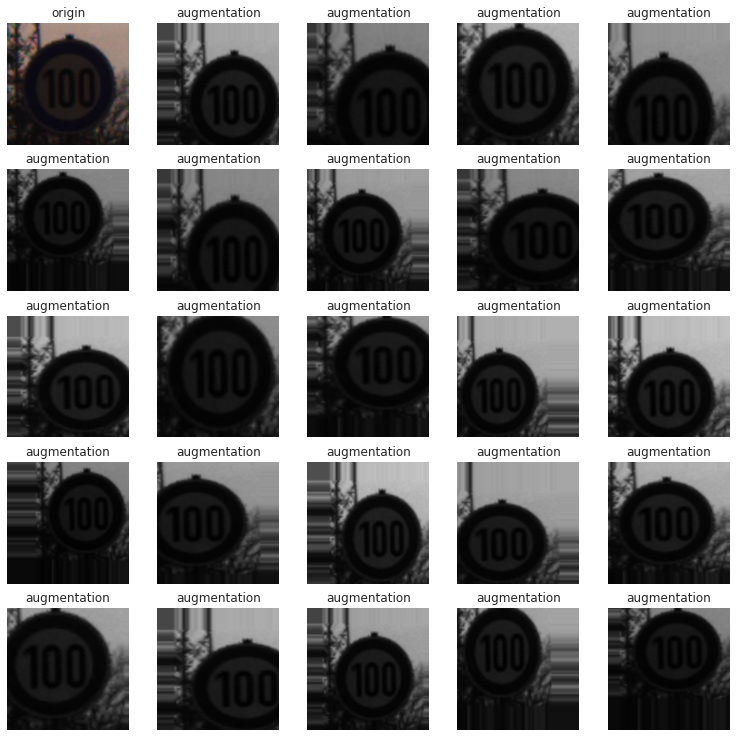

In [16]:
idx = 6768

input_img = np.array([X[idx]])
input_label = y[idx]

generator = train_datagen.flow(input_img, batch_size=1)
preprocess_input = tf.keras.applications.resnet50.preprocess_input

f, axes = plt.subplots(5, 5, figsize=(13, 13))
ax_list = axes.flat
ax_list[0].imshow(input_img[0])
ax_list[0].axis('off')
ax_list[0].set_title("origin")

for i, img in enumerate(generator):
    # plot_img = preprocess_input(img[0])
    plot_img = img[0]/255.0
    ax_list[i+1].imshow(plot_img)
    ax_list[i+1].axis('off')   
    ax_list[i+1].set_title("augmentation")
    if i > 22:
        break

### 모델 생성

In [41]:
IMG_SHAPE = (height, width, channels)
preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
n_epochs = 20

In [42]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [43]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer =  Dense(num_classes, activation= 'softmax')

In [44]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0   

### 모델 학습

In [47]:
model_check = ModelCheckpoint('./workplace/model/resnet50_pretrained.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [48]:
history =  model.fit(
    train_generator, 
    batch_size = 32, epochs = n_epochs, verbose = 1, 
    validation_data=valid_generator, 
    callbacks = [model_check, early, reduce_lr]
)

Epoch 1/20
651/651 [==============================] - 258s 391ms/step - loss: 1.3787 - accuracy: 0.5846 - val_loss: 0.5853 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 2/20
651/651 [==============================] - 252s 386ms/step - loss: 0.7134 - accuracy: 0.7585 - val_loss: 0.4795 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 3/20
651/651 [==============================] - 253s 388ms/step - loss: 0.5895 - accuracy: 0.7997 - val_loss: 0.3814 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 4/20
651/651 [==============================] - 253s 389ms/step - loss: 0.5530 - accuracy: 0.8096 - val_loss: 0.3433 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 5/20
651/651 [==============================] - 252s 388ms/step - loss: 0.5348 - accuracy: 0.8181 - val_loss: 0.3462 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 6/20
651/651 [==============================] - 255s 392ms/step - loss: 0.5188 - accuracy: 0.8221 - val_loss: 0.3033 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 7/20
651/651 [==========================

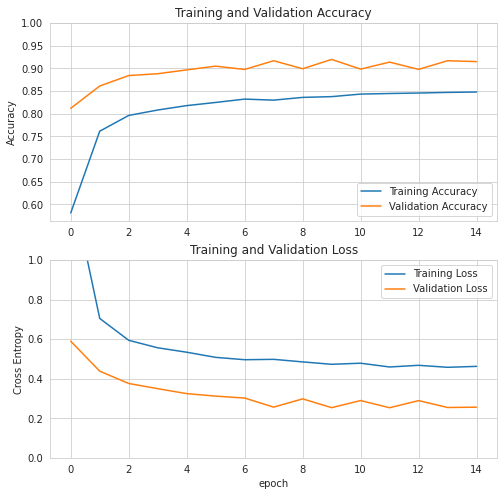

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 모델 fine tuning

In [22]:
base_model.trainable = True

In [23]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
scale_input =  tf.keras.layers.Rescaling(1/255, 0.0)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer =  Dense(num_classes, activation= 'softmax')

In [25]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
# x = scale_input(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
len(model.trainable_variables)

92

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                             

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_check = ModelCheckpoint('./workplace/model/gray_re255_resnet50_pretrained_fine_tuning.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [29]:
fine_tune_epochs = 10
total_epochs =  n_epochs + fine_tune_epochs

history_fine =  model.fit(
    train_generator, 
    batch_size = 32, epochs = total_epochs, verbose = 1, 
    validation_data=valid_generator, 
    callbacks = [model_check, early, reduce_lr]
)

Epoch 1/30
651/651 [==============================] - 371s 550ms/step - loss: 2.0549 - accuracy: 0.4024 - val_loss: 0.8833 - val_accuracy: 0.7313 - lr: 0.0010
Epoch 2/30
651/651 [==============================] - 357s 548ms/step - loss: 0.4835 - accuracy: 0.8502 - val_loss: 0.3353 - val_accuracy: 0.8968 - lr: 0.0010
Epoch 3/30
651/651 [==============================] - 355s 546ms/step - loss: 0.2280 - accuracy: 0.9312 - val_loss: 0.1922 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 4/30
651/651 [==============================] - 355s 546ms/step - loss: 0.1565 - accuracy: 0.9505 - val_loss: 0.2983 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 5/30
651/651 [==============================] - 356s 547ms/step - loss: 0.1158 - accuracy: 0.9648 - val_loss: 0.1919 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 6/30
651/651 [==============================] - 359s 551ms/step - loss: 0.0936 - accuracy: 0.9714 - val_loss: 0.0838 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/30
651/651 [==========================

### 모델 평가

In [60]:
loss, acc = model.evaluate_generator(valid_generator)
print('Accuracy: ', acc, '\nLoss    : ', loss)

Accuracy:  0.9940407276153564 
Loss    :  0.021150968968868256


In [61]:
from sklearn.metrics import classification_report, confusion_matrix

valid_generator.reset()
y_pred = model.predict_generator(valid_generator)
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [62]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      0.98      0.99       252
           2       0.99      0.98      0.99       252
           3       0.98      0.98      0.98       252
           4       1.00      1.00      1.00       252
           5       0.98      0.98      0.98       252
           6       1.00      1.00      1.00        36
           7       0.98      1.00      0.99       252
           8       1.00      1.00      1.00       252
           9       1.00      1.00      1.00       252
          10       1.00      1.00      1.00       252
          11       1.00      1.00      1.00       252
          12       1.00      1.00      1.00       252
          13       1.00      1.00      1.00       252
          14       1.00      1.00      1.00       126
          15       1.00      1.00      1.00       126
          16       1.00      1.00      1.00        36
          17       1.00    

In [66]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

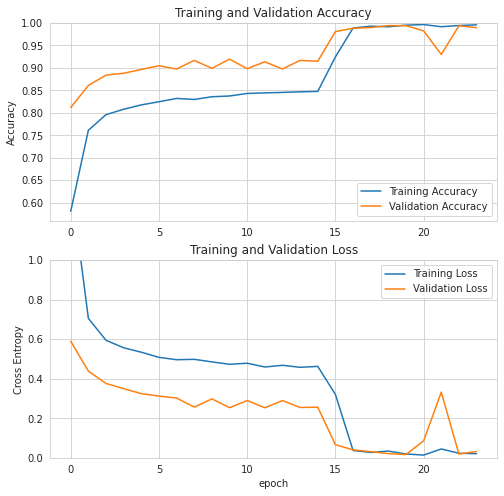

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Ensemble

In [ ]:
model_baseline = create_model(img_rows,img_cols,img_channels)
model_gray_minmax = create_model(img_rows,img_cols,img_channels)
model_gray_contrast_minmax_over = create_model(img_rows,img_cols,img_channels)

model_baseline.load_weights('./workplace/model/model_no_preprocess_94.h5')
model_gray_minmax.load_weights('./workplace/model/mode_gray_minmax.h5')
model_gray_contrast_minmax_over.load_weights('./workplace/model/model_contrast_gray_oversample_minmax_99.h5')


models = [model_baseline, model_gray_minmax, model_gray_contrast_minmax_over]

In [ ]:
def ensemble(models):
    input = Input(shape=(img_rows,img_cols,img_channels))
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(Average, y, name='ensemble')
    return model

In [ ]:
ensemble_model = ensemble(models)

ValueError: ignored

### 모델 테스트

In [ ]:
from tensorflow import keras 
model = keras.models.load_model(model_name)

### 테스트 데이터 예측

In [ ]:
# test_data = []
# file_name = []
# path = f'./data/Test/'
# Class = os.listdir(path)
# for a in Class:
#     image = cv2.imread(path + a)
#     image = img_contrast(image)
#     image_from_array = Image.fromarray(image, 'RGB')
#     size_image = image_from_array.resize((height, width))
#     test_data.append(np.array(size_image))
#     file_name.append(a)

# test_data = np.array(test_data)
# file_name = np.array(file_name)

# import pickle 

# with open('./data/test_data_contrast.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

# with open('./data/file_name_contrast.pkl', 'wb') as f:
#     pickle.dump(file_name, f)

In [ ]:
import pickle
with open('./data/test_data_contrast.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('./data/file_name_contrast.pkl', 'rb') as f:
    file_name = pickle.load(f)

In [ ]:
test_data_origin = test_data

In [ ]:
test_data.shape

(8670, 32, 32, 3)

In [ ]:
test_data = preprocessing(Scaler(test_data, 'MinMax255'))
test_data.shape

(8670, 32, 32, 3)

In [ ]:
record = []
for i in range(test_data.shape[0]):
    record.append(test_data[i])

In [ ]:
record[0].shape

(32, 32, 3)

In [ ]:
pd.DataFrame([record])

,0,1,2,3,4,5,6,7,8,9,...,8660,8661,8662,8663,8664,8665,8666,8667,8668,8669
0,"[[[171, 167, 116], [207, 202, 166], [226, 223,...","[[[232, 226, 218], [172, 195, 209], [80, 112, ...","[[[102, 101, 107], [100, 96, 100], [95, 92, 96...","[[[89, 88, 76], [169, 161, 150], [164, 161, 14...","[[[45, 48, 49], [34, 37, 38], [44, 47, 48], [4...","[[[124, 124, 122], [130, 130, 131], [106, 107,...","[[[79, 125, 159], [143, 184, 217], [144, 173, ...","[[[149, 194, 243], [150, 204, 252], [129, 184,...","[[[225, 221, 210], [255, 255, 255], [252, 249,...","[[[86, 84, 95], [99, 98, 110], [90, 90, 102], ...",...,"[[[38, 36, 39], [37, 36, 39], [36, 35, 36], [4...","[[[122, 121, 118], [135, 137, 130], [89, 92, 8...","[[[97, 123, 145], [78, 102, 120], [46, 58, 73]...","[[[76, 74, 68], [105, 103, 97], [83, 80, 78], ...","[[[82, 86, 92], [149, 153, 158], [136, 142, 15...","[[[28, 31, 36], [30, 32, 37], [36, 39, 44], [4...","[[[84, 90, 86], [99, 104, 101], [121, 132, 132...","[[[93, 90, 97], [141, 140, 159], [154, 153, 17...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[75, 77, 79], [80, 80, 83], [58, 57, 63], [3..."


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(
        test_data,
        batch_size = 32,
        shuffle=False
) 

In [ ]:
test_generator.reset()
test_label = model.predict_generator(test_generator)
test_label = tf.argmax(test_label, axis=1).numpy()

In [ ]:
def show_label_image(data, label, file_name, category):
    fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize=(18, 18))
    img_filter = np.argwhere(label==category).reshape(-1)
    img = data[img_filter]
    name = file_name[img_filter]
    index = np.random.choice(list(range(len(img))), 100)
    for i, ax in enumerate(axes.flat):
        r = index[i]
        ax.imshow(img[r])
        ax.set_title(name[r], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

In [ ]:
def show_sample_image(data, label, category):
    fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize=(10, 10))
    img_filter = np.argwhere(label==category).reshape(-1)
    img = data[img_filter]
    index = np.random.choice(list(range(len(img))), 25)
    for i, ax in enumerate(axes.flat):
        r = index[i]
        ax.imshow(img[r])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

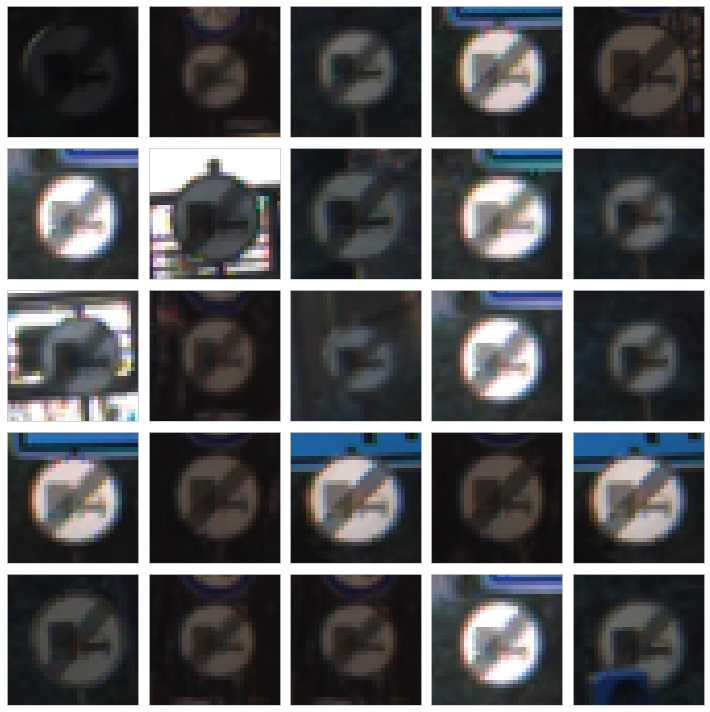

In [ ]:
show_sample_image(data, labels, 42)

In [ ]:
img_data = [np.array(x) for x in test_data_origin]
img_df = pd.DataFrame({'img':img_pandas, 'file_name':file_name})
v2_label = pd.read_csv('./data/v2_label.csv', header=None)
v2_label.columns = ['file_name','label']

In [ ]:
debug_data = pd.merge(img_df, v2_label, on='file_name').sort_values(by=['file_name'])

In [ ]:
def debug_image(debug_data, category, next_file=None):
    filter_data = debug_data[debug_data['label']==category].reset_index()
    if next_file is not None:
        filter_data = filter_data[filter_data['file_name'] > next_file]

    fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize=(18, 23))
    for i, ax in enumerate(axes.flat):
        record = filter_data.iloc[i]
        img = record['img']
        file_name = record['file_name']
        ax.imshow(img)
        ax.set_title(file_name, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

IndexError: ignored

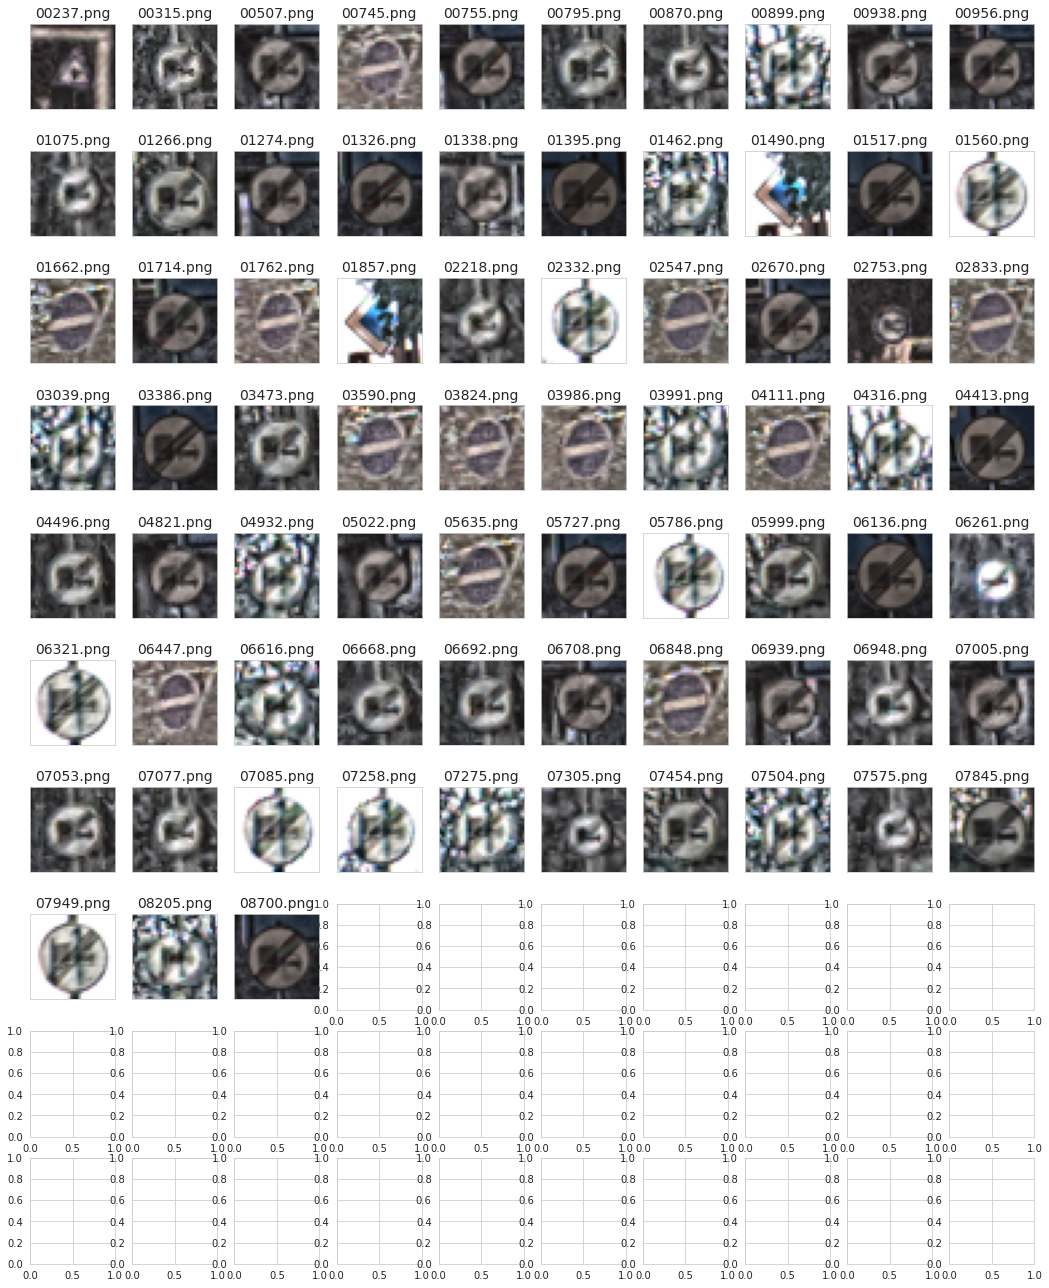

In [ ]:
debug_image(debug_data, 42)

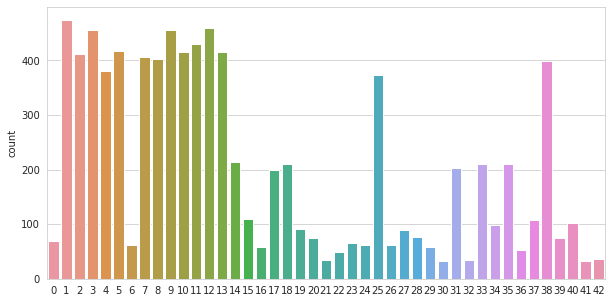

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(test_label)

In [ ]:
csv_data = pd.DataFrame(np.concatenate((file_name.reshape(-1, 1), test_label.reshape(-1,1)), axis=1))

In [ ]:
csv_data = csv_data.sort_values(by=[0])
csv_data.head()

,0,1
279,00000.png,16
8119,00001.png,1
3628,00002.png,38
1565,00003.png,33
5360,00004.png,11


In [ ]:
csv_data.to_csv("predicted_output_v4.csv", header=False, index=False)

In [ ]:
from google.colab import files
files.download("predicted_output_v4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 주석

살짝 로테이션 줘야하나

```python
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=add_noise,
    )
```

```python
def get_ensemble():
	# define the base models
	models = list()
	# normalization
	norm = Pipeline([('s', MinMaxScaler()), ('m', DecisionTreeClassifier())])
	models.append(('norm', norm))
	# standardization
	std = Pipeline([('s', StandardScaler()), ('m', DecisionTreeClassifier())])
	models.append(('std', std))
	# robust
	robust = Pipeline([('s', RobustScaler()), ('m', DecisionTreeClassifier())])
	models.append(('robust', robust))
	# power
	power = Pipeline([('s', PowerTransformer()), ('m', DecisionTreeClassifier())])
	models.append(('power', power))
	# quantile
	quant = Pipeline([('s', QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m', DecisionTreeClassifier())])
	models.append(('quant', quant))
	# kbins
	kbins = Pipeline([('s', KBinsDiscretizer(n_bins=20, encode='ordinal')), ('m', DecisionTreeClassifier())])
	models.append(('kbins', kbins))
	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble
```
